# **라이브러리 불러오기**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

# **[데이터 살펴보기]**

In [3]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [4]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [5]:
print(train.shape,test.shape)

(26457, 20) (10000, 19)


In [6]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

# **[데이터 전처리]**

**(주의) train data에 해준 그대로 test data 전처리**

## **1. 결측치 제거** 

In [7]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [8]:
test.isna().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

# Feature Engineering

## Responsible Variable

In [9]:
train.credit.value_counts(normalize= True)

2.0    0.641343
1.0    0.236875
0.0    0.121783
Name: credit, dtype: float64

## Features

### ID생성 / 중복컬럼 제거


In [10]:
train['ID'] = \
train['child_num'].astype(str) + '_' + train['income_total'].astype(str) + '_' +\
train['DAYS_BIRTH'].astype(str) + '_' + train['DAYS_EMPLOYED'].astype(str) + '_' +\
train['work_phone'].astype(str) + '_' + train['phone'].astype(str) + '_' +\
train['email'].astype(str) + '_' + train['family_size'].astype(str) + '_' +\
train['gender'].astype(str) + '_' + train['car'].astype(str) + '_' +\
train['reality'].astype(str) + '_' + train['income_type'].astype(str) + '_' +\
train['edu_type'].astype(str) + '_' + train['family_type'].astype(str) + '_' +\
train['house_type'].astype(str) + '_' + train['occyp_type'].astype(str)

# test['ID'] = \
# test['child_num'].astype(str) + '_' + test['income_total'].astype(str) + '_' +\
# test['DAYS_BIRTH'].astype(str) + '_' + test['DAYS_EMPLOYED'].astype(str) + '_' +\
# test['work_phone'].astype(str) + '_' + test['phone'].astype(str) + '_' +\
# test['email'].astype(str) + '_' + test['family_size'].astype(str) + '_' +\
# test['gender'].astype(str) + '_' + test['car'].astype(str) + '_' +\
# test['reality'].astype(str) + '_' + test['income_type'].astype(str) + '_' +\
# test['edu_type'].astype(str) + '_' + test['family_type'].astype(str) + '_' +\
# test['house_type'].astype(str) + '_' + test['occyp_type'].astype(str)

In [20]:
train['begin_month']=-train['begin_month']  
test['begin_month']=-test['begin_month']    
train.sort_values(by=['begin_month'], axis=0).drop_duplicates(['ID'], keep='first')

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,ID
20098,20098,F,N,Y,1,112500.0,State servant,Secondary / secondary special,Married,House / apartment,-14887,-2599,0,0,0,3.0,-0.0,0.0,1_112500.0_-14887_-2599_0_0_0_3.0_F_N_Y_State ...
19861,19861,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-23183,365243,0,1,0,1.0,-0.0,1.0,0_135000.0_-23183_365243_0_1_0_1.0_F_N_Y_Pensi...
23760,23760,M,Y,N,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,-10191,-2218,0,0,0,2.0,-0.0,0.0,0_202500.0_-10191_-2218_0_0_0_2.0_M_Y_N_Workin...
9553,9553,M,N,N,0,180000.0,Commercial associate,Higher education,Civil marriage,House / apartment,-19365,-243,0,0,1,2.0,-0.0,0.0,0_180000.0_-19365_-243_0_0_1_2.0_M_N_N_Commerc...
16233,16233,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20726,365243,0,0,0,2.0,-0.0,1.0,0_90000.0_-20726_365243_0_0_0_2.0_F_N_Y_Pensio...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24612,24612,F,N,Y,3,180000.0,State servant,Higher education,Married,House / apartment,-11627,-1449,1,0,0,5.0,60.0,2.0,3_180000.0_-11627_-1449_1_0_0_5.0_F_N_Y_State ...
15463,15463,F,N,N,0,112500.0,Working,Higher education,Married,With parents,-10650,-3702,1,1,0,2.0,60.0,2.0,0_112500.0_-10650_-3702_1_1_0_2.0_F_N_N_Workin...
18573,18573,F,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-11210,-1724,1,0,0,2.0,60.0,2.0,0_256500.0_-11210_-1724_1_0_0_2.0_F_Y_Y_Commer...
15501,15501,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-18670,365243,0,0,0,1.0,60.0,2.0,0_67500.0_-18670_365243_0_0_0_1.0_F_N_Y_Pensio...


In [69]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

train.drop("FLAG_MOBIL", axis=1, inplace= True)
test.drop("FLAG_MOBIL", axis=1, inplace= True)

In [21]:
ivtable=pd.DataFrame(train.columns,columns=['variable'])
ivtable['IV']=None

ivtable.drop(ivtable[ivtable['variable'] == "begin_month"].index, inplace=True)
ivtable.drop(ivtable[ivtable['variable'] == "credit"].index, inplace=True)
ivtable.drop(ivtable[ivtable['variable'] == "index"].index, inplace=True)


## **2. Binary variables**

* Define calc_iv function to calculate Information Value and WOE Value

In [22]:
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])
    
    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())

    return iv, data

In [23]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [24]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

* gender, car, reality, phone,  email, work_phone

In [26]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
train['car'] = train['car'].replace(['N','Y'],[0,1])
train['reality'] = train['reality'].replace(['N','Y'],[0,1])

test['gender'] = test['gender'].replace(['F','M'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])


In [27]:
binary= ['gender','car', 'reality', 'phone',  'email', 'work_phone']
for i in binary: 
    print(train[i].value_counts(normalize=True,sort=False))
    iv, data = calc_iv(train,i,'credit')
    ivtable.loc[ivtable['variable']==i,'IV']=iv
    print(data.head())
    print("-"* 60)

0    0.668897
1    0.331103
Name: gender, dtype: float64
This variable's IV is: 0.00015540835717678462
0    17697
1     8760
Name: gender, dtype: int64
  Variable  Value    All  Good   Bad     Share  Bad Rate  Distribution Good  \
0   gender      0  17697  2148  4220  0.668897  0.238458           0.667509   
1   gender      1   8760  1074  2047  0.331103  0.233676           0.332491   

   Distribution Bad       WoE        IV  
0          0.673368 -0.008740  0.000051  
1          0.326632  0.017781  0.000104  
------------------------------------------------------------
0    0.620252
1    0.379748
Name: car, dtype: float64
This variable's IV is: 0.0019768576336425905
0    16410
1    10047
Name: car, dtype: int64
  Variable  Value    All  Good   Bad     Share  Bad Rate  Distribution Good  \
0      car      0  16410  1982  3990  0.620252  0.243144           0.615156   
1      car      1  10047  1240  2277  0.379748  0.226635           0.384844   

   Distribution Bad       WoE        IV 

## **3. Continuous variable**

### (1) child_num

<AxesSubplot:>

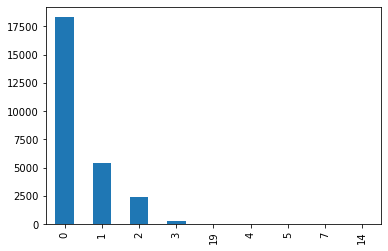

In [28]:
train['child_num'].value_counts(sort=False).plot.bar()

In [29]:
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num'] >= 2,'child_num']=2


iv, data=calc_iv(train,'child_num','credit')
ivtable.loc[ivtable['variable']=='child_num','IV']=iv
data.head()

This variable's IV is: 0.000420389473080061
0    18340
1     5386
2     2731
Name: child_num, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,child_num,0,18340,2233,4322,0.693200,0.235660,0.694304,0.689644,0.006734,0.000031
1,child_num,1,5386,682,1313,0.203576,0.243780,0.201734,0.209510,-0.037824,0.000294
2,child_num,2,2731,307,632,0.103224,0.231417,0.103962,0.100846,0.030437,0.000095


In [30]:
train = convert_dummy(train,'child_num')
test = convert_dummy(test,'child_num')

### (2) inc

bins the data based on sample quantiles

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

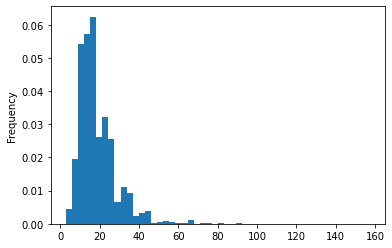

In [31]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000 
test['income_total'] = test['income_total']/10000
##############################################################3
print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [32]:
# count, bin_dividers =np.histogram(train['income_total'], bins=7)
# bin_names=['소득'+str(i) for i in range(7) ]
# #bin_dividers는 train기준!!
# train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
# test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)


In [33]:
train = get_category(train,'income_total', 3, ["low","medium", "high"], qcut = True)
test = get_category(test,'income_total', 3, ["low","medium", "high"], qcut = True)

iv, data = calc_iv(train,'gp_income_total','credit')
ivtable.loc[ivtable['variable']=='income_total','IV']=iv
data.head()

This variable's IV is: 0.0031869062591340074
low       10478
high       8269
medium     7710
Name: gp_income_total, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_income_total,high,8269,1012,1849,0.312545,0.223606,0.317979,0.295037,0.074884,0.001718
1,gp_income_total,low,10478,1232,2598,0.396039,0.247948,0.390292,0.414552,-0.060304,0.001463
2,gp_income_total,medium,7710,978,1820,0.291416,0.236057,0.291729,0.290410,0.004530,0.000006


In [34]:
train = convert_dummy(train,'gp_income_total')
test = convert_dummy(test,'gp_income_total')

### **(3) Age**

Bucketing Continuous Variables

(20.951999999999998, 25.7]    0.034169
(25.7, 30.4]                  0.129266
(30.4, 35.1]                  0.141210
(35.1, 39.8]                  0.118419
(39.8, 44.5]                  0.139509
(44.5, 49.2]                  0.116340
(49.2, 53.9]                  0.087727
(53.9, 58.6]                  0.107004
(58.6, 63.3]                  0.091091
(63.3, 68.0]                  0.035265
Name: Age, dtype: float64
(19.951, 24.8]    0.0192
(24.8, 29.6]      0.1128
(29.6, 34.4]      0.1370
(34.4, 39.2]      0.1481
(39.2, 44.0]      0.1442
(44.0, 48.8]      0.0897
(48.8, 53.6]      0.1127
(53.6, 58.4]      0.1068
(58.4, 63.2]      0.0918
(63.2, 68.0]      0.0377
Name: Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

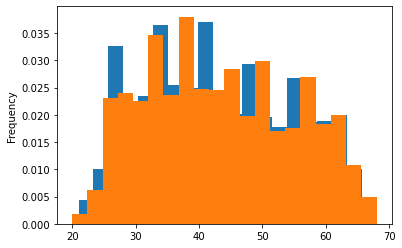

In [35]:
train['Age']= -(train['DAYS_BIRTH'])//365	
print(train['Age'].value_counts(bins=10,normalize=True,sort=False))
train['Age'].plot(kind='hist',bins=20,density=True)

test['Age']= -(test['DAYS_BIRTH'])//365	
print(test['Age'].value_counts(bins=10,normalize=True,sort=False))
test['Age'].plot(kind='hist',bins=20,density=True)

In [36]:
train = get_category(train,'Age',5, ["lowest","low","medium","high","highest"])
test = get_category(test,'Age',5, ["lowest","low","medium","high","highest"])

iv, data = calc_iv(train,'gp_Age','credit')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.011361145096431085
low        6869
medium     6769
high       5152
lowest     4324
highest    3343
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,5152,626,1181,0.194731,0.229231,0.196682,0.188447,0.042767,0.000352
1,gp_Age,highest,3343,385,784,0.126356,0.234520,0.126746,0.125100,0.013073,0.000022
2,gp_Age,low,6869,900,1589,0.259629,0.231329,0.261516,0.253550,0.030932,0.000246
3,gp_Age,lowest,4324,496,1212,0.163435,0.280296,0.154136,0.193394,-0.226896,0.008908
4,gp_Age,medium,6769,815,1501,0.255849,0.221746,0.260921,0.239509,0.085630,0.001834


In [37]:
train = convert_dummy(train,'gp_Age')
test = convert_dummy(test,'gp_Age')

### **(4) Working Years**

Equal-length Bucketing


<AxesSubplot:ylabel='Frequency'>

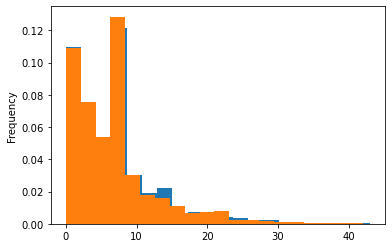

In [38]:
train['worktm']=-(train['DAYS_EMPLOYED'])//365	
train['worktm'][train['worktm']<0] = np.nan # replace by na
train['worktm'].fillna(train['worktm'].mean(),inplace=True) #replace na by mean
train['worktm'].plot(kind='hist',bins=20,density=True)

test['worktm']=-(test['DAYS_EMPLOYED'])//365	
test['worktm'][test['worktm']<0] = np.nan # replace by na
test['worktm'].fillna(test['worktm'].mean(),inplace=True) #replace na by mean
test['worktm'].plot(kind='hist',bins=20,density=True)

In [39]:
train = get_category(train,'worktm',5, ["lowest","low","medium","high","highest"])
test = get_category(test,'worktm',5, ["lowest","low","medium","high","highest"])

iv, data=calc_iv(train,'gp_worktm','credit')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.007996181267715995
lowest     20332
low         4451
medium      1201
high         387
highest       86
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,387,49,76,0.014628,0.196382,0.015404,0.012127,0.239170,0.000784
1,gp_worktm,highest,86,14,19,0.003251,0.220930,0.003318,0.003032,0.090364,0.000026
2,gp_worktm,low,4451,527,923,0.168235,0.207369,0.174740,0.147279,0.170968,0.004695
3,gp_worktm,lowest,20332,2501,4992,0.768492,0.245524,0.759782,0.796553,-0.047262,0.001738
4,gp_worktm,medium,1201,131,257,0.045394,0.213988,0.046756,0.041008,0.131160,0.000754


In [40]:
train = convert_dummy(train,'gp_worktm')
test = convert_dummy(test,'gp_worktm')

### **(5) family_size**

In [41]:
train['family_size'].value_counts(sort=False)

2.0     14106
3.0      4632
4.0      2260
1.0      5109
6.0        44
9.0         2
5.0       291
7.0         9
20.0        1
15.0        3
Name: family_size, dtype: int64

In [42]:
train['family_size']=train['family_size'].astype(int)
train['gp_family_size']=train['family_size']
train['gp_family_size']=train['gp_family_size'].astype(object)
train.loc[train['gp_family_size']>=4,'gp_family_size']='4more'
iv, data=calc_iv(train,'gp_family_size','credit')
ivtable.loc[ivtable['variable']=='family_size','IV']=iv
data.head()

test['family_size']=test['family_size'].astype(int)
test['gp_family_size']=test['family_size']
test['gp_family_size']=test['gp_family_size'].astype(object)
test.loc[test['gp_family_size']>=4,'gp_family_size']='4more'


This variable's IV is: 0.0033005174794380446
2        14106
1         5109
3         4632
4more     2610
Name: gp_family_size, dtype: int64


In [43]:
train = convert_dummy(train,'gp_family_size')
test = convert_dummy(test,'gp_family_size')

## Categorical Features(Type)

In [44]:
print(train['income_type'].value_counts(sort=False))
print(train['income_type'].value_counts(normalize=True,sort=False))
train.loc[train['income_type']=='Student','income_type']='State servant'
test.loc[test['income_type']=='Student','income_type']='State servant'

iv, data=calc_iv(train,'income_type','credit')
ivtable.loc[ivtable['variable']=='income_type','IV']=iv
data.head()

Student                     7
State servant            2154
Commercial associate     6202
Working                 13645
Pensioner                4449
Name: income_type, dtype: int64
Student                 0.000265
State servant           0.081415
Commercial associate    0.234418
Working                 0.515743
Pensioner               0.168160
Name: income_type, dtype: float64
This variable's IV is: 0.00456365322572349
Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2161
Name: income_type, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,income_type,Commercial associate,6202,782,1344,0.234418,0.216704,0.240614,0.214457,0.115087,0.003010
1,income_type,Pensioner,4449,536,1084,0.168160,0.243650,0.166667,0.172970,-0.037120,0.000234
2,income_type,State servant,2161,265,492,0.081680,0.227672,0.082665,0.078506,0.051612,0.000215
3,income_type,Working,13645,1639,3347,0.515743,0.245291,0.510054,0.534067,-0.046004,0.001105


In [45]:
train = convert_dummy(train,'income_type')
test = convert_dummy(test,'income_type')

* House Type

In [46]:
iv, data=calc_iv(train,'house_type','credit')
ivtable.loc[ivtable['variable']=='house_type','IV']=iv
data.head()

This variable's IV is: 0.0071183781316794415
House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,house_type,Co-op apartment,110,14,30,0.004158,0.272727,0.003962,0.004787,-0.189060,0.000156
1,house_type,House / apartment,23653,2873,5569,0.894017,0.235446,0.895691,0.888623,0.007922,0.000056
2,house_type,Municipal apartment,818,110,160,0.030918,0.195599,0.032590,0.025531,0.244141,0.001724
3,house_type,Office apartment,190,24,48,0.007181,0.252632,0.007033,0.007659,-0.085264,0.000053
4,house_type,Rented apartment,429,50,147,0.016215,0.342657,0.013967,0.023456,-0.518415,0.004919


In [47]:
train = convert_dummy(train,'house_type')
test = convert_dummy(test,'house_type')

* Education

In [48]:
train.loc[train['edu_type']=='Academic degree','edu_type']='Higher education'
test.loc[test['edu_type']=='Academic degree','edu_type']='Higher education'

iv, data=calc_iv(train,'edu_type','credit')
ivtable.loc[ivtable['variable']=='edu_type','IV']=iv
data.head()

This variable's IV is: 0.000759479717061222
Secondary / secondary special    17995
Higher education                  7185
Incomplete higher                 1020
Lower secondary                    257
Name: edu_type, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edu_type,Higher education,7185,911,1758,0.271573,0.244676,0.268796,0.280517,-0.042680,0.000500
1,edu_type,Incomplete higher,1020,114,246,0.038553,0.241176,0.038336,0.039253,-0.023649,0.000022
2,edu_type,Lower secondary,257,28,59,0.009714,0.229572,0.009807,0.009414,0.040840,0.000016
3,edu_type,Secondary / secondary special,17995,2169,4204,0.680160,0.233620,0.683061,0.670815,0.018090,0.000222


In [49]:
train = convert_dummy(train,'edu_type')
test = convert_dummy(test,'edu_type')

* Marriage Condition

In [50]:
train['family_type'].value_counts(normalize=True,sort=False)

Separated               0.058170
Single / not married    0.132139
Widow                   0.041690
Married                 0.687757
Civil marriage          0.080243
Name: family_type, dtype: float64

In [51]:
iv, data=calc_iv(train,'family_type','credit')
ivtable.loc[ivtable['variable']=='family_type','IV']=iv
data.head()

This variable's IV is: 0.008138070504547073
Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,family_type,Civil marriage,2123,288,539,0.080243,0.253886,0.078455,0.086006,-0.091897,0.000694
1,family_type,Married,18196,2213,4140,0.687757,0.227523,0.696186,0.660603,0.052464,0.001867
2,family_type,Separated,1539,193,349,0.058170,0.226771,0.058940,0.055689,0.056747,0.000185
3,family_type,Single / not married,3496,402,940,0.132139,0.268879,0.126597,0.149992,-0.169571,0.003967
4,family_type,Widow,1103,126,299,0.041690,0.271079,0.039822,0.047710,-0.180734,0.001426


In [52]:
train = convert_dummy(train,'family_type')
test = convert_dummy(test,'family_type')

In [53]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.0113611
8,family_type,0.00813807
11,worktmgp,0.00799618
9,house_type,0.00711838
6,income_type,0.00456365
15,family_size,0.00330052
5,income_total,0.00318691
3,reality,0.00236652
2,car,0.00197686
13,phone,0.00161202


# Algorithms

* Split Dataset

In [54]:
X = train[['gender', 'reality', 'work_phone', 'child_num_1', 'child_num_2',
       'gp_income_total_high', 'gp_income_total_medium', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_lowest',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'gp_family_size_1', 'gp_family_size_3',
       'gp_family_size_4more', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'house_type_Co-op apartment', 'house_type_Municipal apartment',
       'house_type_Office apartment', 'house_type_Rented apartment',
       'house_type_With parents', 'edu_type_Higher education',
       'edu_type_Incomplete higher', 'edu_type_Lower secondary',
       'family_type_Civil marriage', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow']]
Y = train["credit"]

X_test = test[['gender', 'reality', 'work_phone', 'child_num_1', 'child_num_2',
       'gp_income_total_high', 'gp_income_total_medium', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_lowest',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'gp_family_size_1', 'gp_family_size_3',
       'gp_family_size_4more', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'house_type_Co-op apartment', 'house_type_Municipal apartment',
       'house_type_Office apartment', 'house_type_Rented apartment',
       'house_type_With parents', 'edu_type_Higher education',
       'edu_type_Incomplete higher', 'edu_type_Lower secondary',
       'family_type_Civil marriage', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow']]

In [55]:
Y = Y.astype('int')

In [56]:
Y= Y.reset_index()
X= X.reset_index()
X.drop("index", axis=1, inplace= True)
Y.drop("index", axis=1, inplace= True)


In [57]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, log_loss
# from sklearn.metrics import f1_score
# from tensorflow.keras.utils import to_categorical

# X_train, X_val, y_train, y_val = train_test_split(X,Y,
# stratify=Y, test_size=0.3,random_state = 10086)

# print("Train set: ")
# print(X_train.shape)
# print(y_train.shape)
# print("===========")
# print("Validation set: ")
# print(X_val.shape)
# print(y_val.shape)

## RandomForest

In [58]:
# clf=RandomForestClassifier()
# clf.fit(X_train, y_train)
# y_pred=clf.predict_proba(X_val)

# print(f"log_loss: {log_loss(to_categorical(y_val), y_pred)}")

## LGBM

In [59]:
# model = LGBMClassifier(num_leaves=31,
#                        max_depth=8, 
#                        learning_rate=0.02,
#                        n_estimators=250,
#                        subsample = 0.8,
#                        colsample_bytree =0.8
#                       )
# model.fit(X_train, y_train)
# y_predict = model.predict(X_test)
# print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
# print(pd.DataFrame(confusion_matrix(y_test,y_predict)))


In [60]:
## Models

In [61]:
n_est = 1000
seed = 42
n_fold = 5
n_class = 3

rf_params = {
    'max_depth': 15,
    'min_samples_leaf': 8,
    'random_state': seed
}

lgb_params = {
    'metric': 'multi_logloss',
    'n_estimators': n_est,
    'objective': 'multiclass',
    'random_state': seed,
    'learning_rate': 0.01,
    'min_child_samples': 20,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 64,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'num_class': n_class
}

xgb_params = {
    'metric': 'mlogloss',
    'objective': 'multi:softprob',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'random_state': seed,
    'num_class': n_class,
    'max_depth': 6,
    'n_estimators': n_est,
    'min_child_samples': 20,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
}

In [62]:
#models dictionary

                              
models = {#'RF': RandomForestClassifier(**rf_params)
           'LGBM': LGBMClassifier(num_leaves=31,
                       max_depth=8, 
                       learning_rate=0.02,
                       n_estimators=250,
                       subsample = 0.8,
                       colsample_bytree =0.8)}
            # 'XGB': XGBClassifier(**xgb_params)}
models

{'LGBM': LGBMClassifier(colsample_bytree=0.8, learning_rate=0.02, max_depth=8,
                n_estimators=250, subsample=0.8)}

In [63]:
# X.iloc[[2,3,4,5]]
# Y.iloc[folds[0][0]]

In [64]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skfold.split(X, Y):
        folds.append((train_idx, valid_idx))

pred_dic = {}
pred_test_dic = {}
        
for name in models:
    print(f'Training {name}:')
    pred = np.zeros((X.shape[0], 3), dtype=float)
    pred_test = np.zeros((X_test.shape[0], 3), dtype=float)
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], Y.iloc[train_idx], Y.iloc[valid_idx]
        models[name].fit(X_train, y_train)
        pred[valid_idx] = models[name].predict_proba(X_valid)
        pred_test += models[name].predict_proba(X_test) / 5
        
    pred_dic[name] = pred
    pred_test_dic[name] = pred_test 
    print(f'\tCV Log Loss: {log_loss(Y, pred):.6f}')

#Training LGBM: 	CV Log Loss: 0.939631 -- begin_month 가장 예전만 남길 떼
#Training XGB:          CV Log Loss: 0.952537 -- begin_month 가장 예전만 남길 떼
#Training LGBM: 	CV Log Loss: 0.863236 -- begin_month 가장 최근만 남길 떼

Training LGBM:
	CV Log Loss: 0.863236


In [65]:
print(f'\tCV Log Loss: {log_loss(Y, pred):.6f}')

	CV Log Loss: 0.863236


In [66]:
pred_test_dic["LGBM"]

array([[0.12576896, 0.20494855, 0.66928248],
       [0.12588395, 0.2233604 , 0.65075565],
       [0.12109291, 0.24810391, 0.63080318],
       ...,
       [0.09706476, 0.22904535, 0.67388989],
       [0.12723682, 0.19309808, 0.6796651 ],
       [0.12298326, 0.27025577, 0.60676097]])

In [67]:
pred_df = pd.DataFrame(data=pred_test_dic["LGBM"])
pred_df

,0,1,2
0,0.125769,0.204949,0.669282
1,0.125884,0.223360,0.650756
2,0.121093,0.248104,0.630803
3,0.150558,0.170399,0.679043
4,0.145128,0.227293,0.627579
...,...,...,...
9995,0.132956,0.240743,0.626301
9996,0.140352,0.299888,0.559759
9997,0.097065,0.229045,0.673890
9998,0.127237,0.193098,0.679665


In [68]:
sub = pd.read_csv('sample_submission.csv', index_col='index')
sub[sub.columns] = pred_df.values
sub
sub.to_csv('submission0428_1.csv')